<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/base_cnn/Acc_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Speech Accent Classifier Project

**Members**: 
Catherine Glossop, Julia Chae, Mingshi Chi, Rocco Ruan 



## Set Up

In [30]:
# package imports 

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display


In [31]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc', transform=data_transform)
  return data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc_npy', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()


In [33]:
# train utils 

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

## Preparing & Visualizing Dataset

(27, 3, 128, 170)


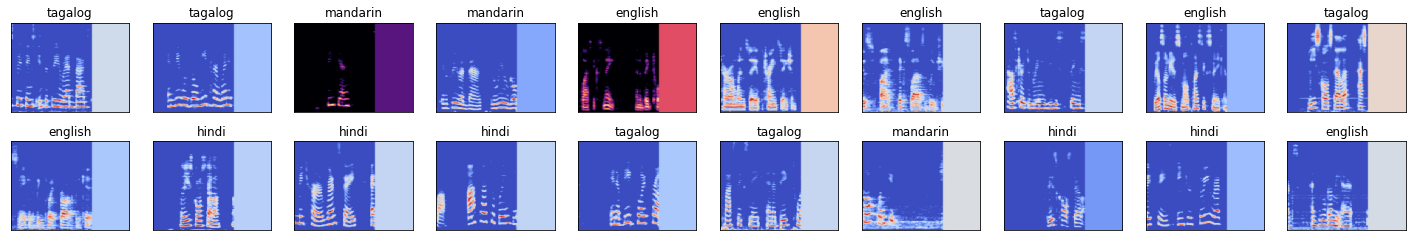

In [66]:
dataset= generate_data_image()
visualize_image_data(dataset)

## Accent Classifier Architecture


## Training 

In [43]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            #val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%10==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
    
    plot_graphs(iters, losses, [], train_acc, [])
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))
    

## Baseline Experimentation

In [71]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_1.0'
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(29*39*10, 560)
          self.fc2 = nn.Linear(560, 9)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 29*39*10)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3013513513513513 Progress:   1.67  % Time Elapsed:  11.88 s 
Epoch 0 Finished.  Time per Epoch:  11.88 s 
Epoch:  1 Train Accuracy:  0.33783783783783783 Progress:   3.33  % Time Elapsed:  23.94 s 
Epoch 1 Finished.  Time per Epoch:  11.97 s 
Epoch:  2 Train Accuracy:  0.3533783783783784 Progress:   5.00  % Time Elapsed:  36.12 s 
Epoch 2 Finished.  Time per Epoch:  12.04 s 
Epoch:  3 Train Accuracy:  0.3439189189189189 Progress:   6.67  % Time Elapsed:  48.29 s 
Epoch 3 Finished.  Time per Epoch:  12.07 s 
Epoch:  4 Train Accuracy:  0.3668918918918919 Progress:   8.33  % Time Elapsed:  60.25 s 
Epoch 4 Finished.  Time per Epoch:  12.05 s 
Epoch:  5 Train Accuracy:  0.3614864864864865 Progress:  10.00  % Time Elapsed:  72.21 s 
Epoch 5 Finished.  Time per Epoch:  12.04 s 
Epoch:  6 Train Accuracy:  0.38175675675675674 Progress:  11.67  % Time Elapsed:  84.28 s 
Epoch 6 Finished.  Time per Epoch:  12.04 s 
Epoch:  7 Train Accuracy:  0.3716216216216

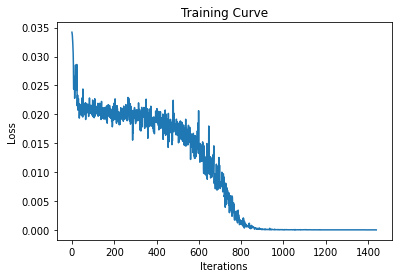

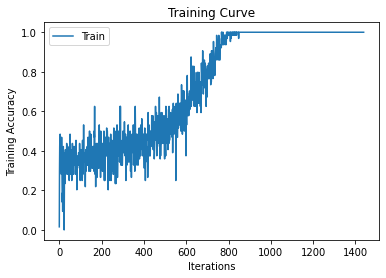

Finished Training
Total time:   725.66 s  Time per Epoch:  12.09 s 


In [73]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 64
num_epochs = 60
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, num_epochs = num_epochs)

In [74]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_1.0'
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(29*39*10, 200)
          self.fc2 = nn.Linear(200, 9)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 29*39*10)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3331081081081081 Progress:   2.00  % Time Elapsed:  11.95 s 
Epoch 0 Finished.  Time per Epoch:  11.95 s 
Epoch:  1 Train Accuracy:  0.32094594594594594 Progress:   4.00  % Time Elapsed:  23.89 s 
Epoch 1 Finished.  Time per Epoch:  11.95 s 
Epoch:  2 Train Accuracy:  0.3493243243243243 Progress:   6.00  % Time Elapsed:  35.81 s 
Epoch 2 Finished.  Time per Epoch:  11.94 s 
Epoch:  3 Train Accuracy:  0.36486486486486486 Progress:   8.00  % Time Elapsed:  47.82 s 
Epoch 3 Finished.  Time per Epoch:  11.96 s 
Epoch:  4 Train Accuracy:  0.34594594594594597 Progress:  10.00  % Time Elapsed:  59.74 s 
Epoch 4 Finished.  Time per Epoch:  11.95 s 
Epoch:  5 Train Accuracy:  0.3560810810810811 Progress:  12.00  % Time Elapsed:  71.80 s 
Epoch 5 Finished.  Time per Epoch:  11.97 s 
Epoch:  6 Train Accuracy:  0.3716216216216216 Progress:  14.00  % Time Elapsed:  83.80 s 
Epoch 6 Finished.  Time per Epoch:  11.97 s 
Epoch:  7 Train Accuracy:  0.370270270270

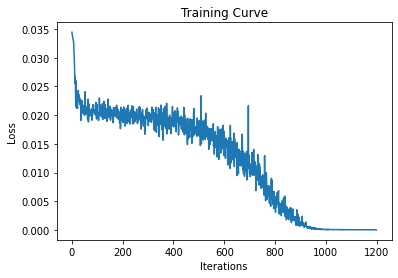

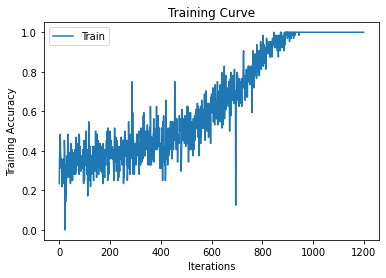

Finished Training
Total time:   602.62 s  Time per Epoch:  12.05 s 


In [75]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 64
num_epochs = 50
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, num_epochs = num_epochs)